# Précision > 99,5%

Modification du meilleur réseau convolutionel pour intégrer la batch norm.

In [54]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [55]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255.
x_test  = x_test/255.
y_train = to_categorical(y_train, dtype='int8')
y_test  = to_categorical(y_test, dtype='int8')

train_size = x_train.shape[0] # Nombre de ligne de la matrice x_train
test_size  = x_test.shape[0]

In [56]:
# Hyperparamètres
#
# Nombre d'époques pour l'apprentissage:
n_epoch = 30

# Taille du batch d'entraînement:
batch_size = 100

# Taux de dropout rate
dropout_rate_param = 0.1

# Incrément pour l'apprentissage
starter_learning_rate = 0.005
# taux de décroissance du pas d'apprentissage
decay_rate = 0.7
# Nombre d'époques à faire avant de changer de pas
decay_epoch = 3

Pas de paramètre $\gamma$ de mise à l'échelle (`Scale`) dans le cas de `relu`, la forme de la courbe n'imposant pas de zone de travail optimum.

In [57]:
def batch_norm(Ylogits, Offset, convolutional = True):
    if convolutional :
        mean, variance = tf.nn.moments(Ylogits, axes=[0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
        
    Ybn = tf.nn.batch_normalization(
        Ylogits,
        mean = mean,
        variance = variance,
        scale = None,
        offset = Offset,
        variance_epsilon = 1e-5,
        name=None
        )
    return Ybn

In [58]:
# dropout_rate: probabilité qu'un neurone soit supprimé (doit être = 0 lors de la phase de test)
dropout_rate = tf.placeholder(tf.float32)


X = tf.placeholder(tf.float32, shape=(None,28,28))
Xd = tf.reshape(X, [-1,28,28,1])

W1 = tf.Variable(tf.truncated_normal([6,6,1,12], stddev=0.1))
O1 = tf.Variable(tf.ones([12])/10)
stride1 = 1
Ycnv1 = tf.nn.conv2d(Xd, W1, strides=[1, stride1, stride1, 1], padding='SAME')
Ybn1 = batch_norm(Ycnv1, O1)
Y1 = tf.nn.relu(Ybn1)
Ydo1 = tf.nn.dropout(Y1, rate=dropout_rate)


W2 = tf.Variable(tf.truncated_normal([5,5,12,12], stddev=0.1))
O2 = tf.Variable(tf.ones([12])/10)
stride2 = 2
Ycnv2 = tf.nn.conv2d(Ydo1, W2, strides=[1,stride2,stride2,1], padding='SAME')
Ybn2 = batch_norm(Ycnv2, O2)
Y2 = tf.nn.relu(Ybn2)
Ydo2 = tf.nn.dropout(Y2, rate=dropout_rate)


W3 = tf.Variable(tf.truncated_normal([4,4,12,24], stddev=0.1))
O3 = tf.Variable(tf.ones([24])/10)
stride3 = 2
Ycnv3 = tf.nn.conv2d(Ydo2, W3, strides=[1,stride3,stride3,1], padding='SAME')
Ybn3 = batch_norm(Ycnv3, O3)
Y3 = tf.nn.relu(Ybn3)
Ydo3 = tf.nn.dropout(Y3, rate=dropout_rate)

Yv3 = tf.reshape(Ydo3, [-1, 7*7*24])

W4 = tf.Variable(tf.truncated_normal([7*7*24,200], stddev=0.1))
O4 = tf.Variable(tf.ones([200])/10)
Ybn4 = batch_norm(tf.matmul(Yv3,W4), O4, convolutional = False)
Y4 = tf.nn.relu(Ybn4)
Ydo4 = tf.nn.dropout(Y4, rate=dropout_rate)

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
b5 = tf.Variable(tf.zeros([10]))
Ylogits = tf.matmul(Ydo4,W5) + b5
Y = tf.nn.softmax(Ylogits)

In [59]:
Y_ = tf.placeholder(tf.float32, shape=(None,10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_sum(cross_entropy)

is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_epoch*train_size//batch_size, decay_rate, staircase=True)

# Optimisation
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy, global_step=global_step)

In [60]:
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []
i_best = 0
accuracy_best = 0

In [61]:
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)
print('Epoque: ')

for i in range(n_epoch*train_size//100):
    epoch = (i*100)//train_size + 1
    
    # Chargement d'un batch d'images et de réponses correctes correspondantes
    batch_train_X  = x_train[(i*100)%train_size:((i+1)*100)%train_size]
    batch_train_Y_ = y_train[(i*100)%train_size:((i+1)*100)%train_size]
    # Dictionnaire de données en entrée
    train_data = {X: batch_train_X, Y_: batch_train_Y_, dropout_rate:dropout_rate_param}

    # train
    sess.run(train_step, feed_dict=train_data)
    
    # Visualisation de la progression
    if not (i*100)%(train_size):
        #Affichage de l'évolution en ligne
        print(epoch, ' ', end='')
    if not i%50:
        # Pour le batch d'entraînement
        acc, loss  = sess.run([accuracy, cross_entropy], feed_dict=train_data)
        accuracy_train.append(acc)
        loss_train.append(loss/batch_size)
        
        # Pour le test: évaluation sur tout l'ensemble des données
        test_data = {X: x_test, Y_: y_test, dropout_rate:0}
        acc, loss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
        accuracy_test.append(acc)
        loss_test.append(loss/test_size)
        if acc>accuracy_best:
            accuracy_best = acc
            i_best = i

Epoque: 
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  

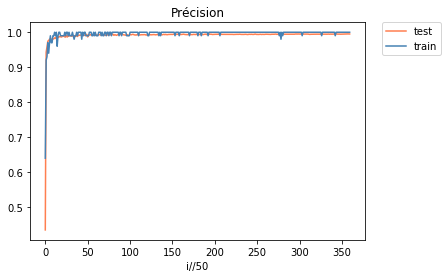

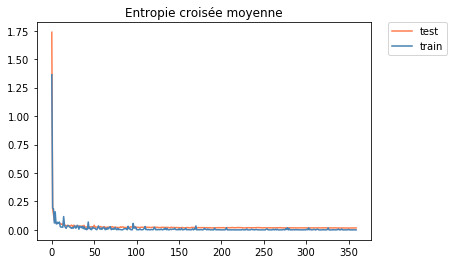

Best score for iteration 17850 	| Accuracy = 0.9952


In [62]:
# Représentation des résultats
# Précision
plt.plot(accuracy_test, c='coral', label='test')
plt.plot(accuracy_train, c='steelblue', label='train')
plt.xlabel('i//50')
plt.title('Précision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Fonction de coût
plt.plot(loss_test, c='coral', label='test')
plt.plot(loss_train, c='steelblue', label='train')
plt.title('Entropie croisée moyenne')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
# Meilleur résultat sur un batch de test
print("Best score for iteration {} \t| Accuracy = {:.4f}".format(i_best, accuracy_best ))

In [63]:
sess.close()

Best score for iteration 17850 	| Accuracy = 0.9952

99.52 % de taux de reconnaissance sur le jeu de test. Mission réussie :)